In [1]:

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'


In [2]:


import numpy as np
import jax.numpy as jnp


In [3]:
#A[2:-1:2, 1:-2:2, 3::2]

tt = np.arange(0,10)
tt,tt[0:-2:2],np.roll(tt,-1)[::2]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 2, 4, 6]),
 array([1, 3, 5, 7, 9]))

In [4]:
from multigrid_gs import *

In [5]:
N = 256

F = jnp.zeros((N,N,N))
F = F.at[N//2,N//2,N//2].set(10)
U = jnp.zeros_like(F)

In [6]:
a = poisson_multigrid(jnp.array(F), jnp.array(U), 3, 1, 1, 1, 2)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


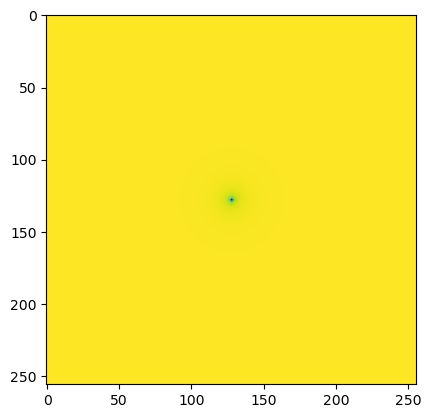

In [7]:
%pylab inline

imshow(a[N//2])
show()


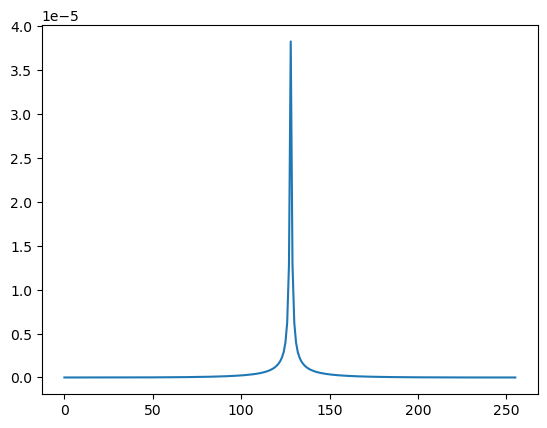

In [8]:
plt.plot(-a[N//2,N//2])

In [9]:
def likelihood(F):
    return jnp.sum(poisson_multigrid(F, U, 0, 1, 1, 1, 2)**2)

In [10]:
likelihood(F)

Array(8.630269e-08, dtype=float32)

In [11]:
%timeit likelihood(F)

35.5 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
like_grad = jax.grad(likelihood)

In [13]:
grad_val = like_grad(F)

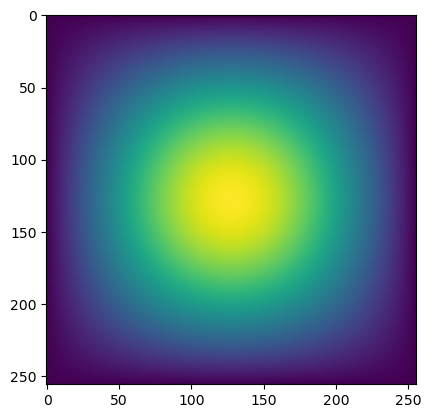

In [14]:
imshow(grad_val[10])
#makes sense due to the boundary conditions terminating the effects near bondaries!

In [15]:
%timeit like_grad(F)

334 ms ± 93.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit likelihood(F)

38.3 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
#grad takes 10x time, but brute force would take ~20,000,000x times, so happy about it :P

In [18]:

def fftk(shape, symmetric=True, finite=False, dtype=np.float32):
  """ Return k_vector given a shape (nc, nc, nc) and box_size
  """
  k = []
  for d in range(len(shape)):
    kd = np.fft.fftfreq(shape[d])
    kd *= 2 * np.pi
    kdshape = np.ones(len(shape), dtype='int')
    if symmetric and d == len(shape) - 1:
      kd = kd[:shape[d] // 2 + 1]
    kdshape[d] = len(kd)
    kd = kd.reshape(kdshape)

    k.append(kd.astype(dtype))
  del kd, kdshape
  return k



def laplace_kernel(kvec):
    """
  Compute the Laplace kernel from a given K vector
  Parameters:
  -----------
  kvec: array
    Array of k values in Fourier space
  Returns:
  --------
  wts: array
    Complex kernel
  """
    kk = sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1. / kk
    imask = (~(kk == 0)).astype(int)
    wts *= imask
    return wts




kvec = fftk((N,N,N))
@jax.jit
def fft_potential(b):
    delta_k = jnp.fft.rfftn(b.reshape(N,N,N))
    laplace = laplace_kernel(kvec)
    pot_k = delta_k * laplace
    pot = jnp.fft.irfftn(pot_k)
    return pot

In [19]:
fft_potential(F)

/tmp/ipykernel_63746/2256777352.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


Array([[[-0.00249222, -0.00249212, -0.00249182, ..., -0.00249133,
         -0.00249182, -0.00249212],
        [-0.00249212, -0.00249202, -0.00249172, ..., -0.00249123,
         -0.00249172, -0.00249202],
        [-0.00249182, -0.00249172, -0.00249143, ..., -0.00249093,
         -0.00249143, -0.00249172],
        ...,
        [-0.00249133, -0.00249123, -0.00249093, ..., -0.00249043,
         -0.00249093, -0.00249123],
        [-0.00249182, -0.00249172, -0.00249143, ..., -0.00249093,
         -0.00249143, -0.00249172],
        [-0.00249212, -0.00249202, -0.00249172, ..., -0.00249123,
         -0.00249172, -0.00249202]],

       [[-0.00249212, -0.00249202, -0.00249172, ..., -0.00249122,
         -0.00249172, -0.00249202],
        [-0.00249202, -0.00249192, -0.00249162, ..., -0.00249112,
         -0.00249162, -0.00249192],
        [-0.00249172, -0.00249162, -0.00249132, ..., -0.00249083,
         -0.00249132, -0.00249162],
        ...,
        [-0.00249122, -0.00249112, -0.00249083, ..., -

In [20]:
%timeit fft_potential(F)

1.96 ms ± 468 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
